<h1 style='text-align: center;'> Part A - Tweets Analysis </h1>
<h3 style='text-align: center;'> Group T, IDs: 316398387 ,318481447</h3>

In this part we are willing to apply a comprehensive data analysis, to get a grasp of how the tweets look like. We will use only two columns, the label and the tweet itself. Before visualizing the content of the tweets and watching how the words distributed, we will do some setup. We assume that if someone uses this notebook he has a .env file in the root directory to use github repo tokens and the weights and biases api(which assumes we have a token to run experiments). <br><br>
_quick note: the %%capture magic line is to direct the cell output to other spot so there won't be a lot of red warnings outputs which are based on packages internals_

In [78]:
%%capture 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from decouple import Config, RepositoryEnv 
import emoji
from langdetect import detect, DetectorFactory
from ftfy import fix_text
import re
import nltk
from nltk.corpus import stopwords
import wandb
from transformers import AutoTokenizer
from wordcloud import WordCloud
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
wandb.login(key=Config(RepositoryEnv("./.env")).get('wandb_api_key'));  # If not necessary comment this line of W&B"

In [79]:
train_org = pd.read_csv("Corona_NLP_train.csv", encoding="latin-1"); train = train_org.loc[:, ['OriginalTweet', 'Sentiment']]
test_org = pd.read_csv("Corona_NLP_test.csv"); test = test_org.loc[:, ['OriginalTweet', 'Sentiment']]

In the past there was aggressive pre-processing and data cleaning step on a textual data. Stemming, lemmatization, stop words removal etc. But these days, because we will use in this course a Transformer based models and architecture, their tokenizers help in the process. <br><br>
Based on related work we attached in the final report, there is a motivation not to do a serious work on the data if not necessary because we might loose context which is important no matter if it is a encoder or decoder based models. So we decided to see how the tweets data look like, what will stay and what not based on research and knowledge about the tokenizers behavior and the important things that were necessary in this process were made and done. <br><br>

Tweets use a lot of sign where in the past were treated as garbage but today we don't have to apply much preprocessing and we will explain why and where we do. <br>
Before we started we looked at the data and saw some unknows signs like: 
regionÂs, which do not say much but are encoded as \x92 which is encoding we have to deal with before even applying a lowercasing. The example that lead us to it was

In [80]:
train.iloc[5,:]

OriginalTweet    As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU
Sentiment                                                                                                                                                                                                                                                          Positive
Name: 5, dtype: object

So we decided to use `fix_text` method from ftfy known library where it will convert all "unknown" encoded text - to a useful content. the above tweet will be: <br>
`As news of the region's first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU")`
<br><br>
We also noticed there are tweets look like that: *@menyrbie @phil_gahan @chrisitv and and* where most of the words in the tweet are just tags of user in tweeter. So we removed them also. <br><br>
Later we saw that there might be also unknowd emojis in several tweets, but using the basic "emoji" python package gave us the copyright and R sign which werent very useful. It is related to the encoding format, we knew that in context based models(such as transformers) emojis can take crucial part in sentiment analysis, but here there weren't much tweets as we expected so we replaced all "like-emoji" type of signs - to a space string ' '. For all of that we will use regular expressions.<br><br>

We also noticed that not all tweets are in english, this plot shows the language distribution:

In [81]:
DetectorFactory.seed = 0   # for easy reproducibility

def safe_lang(text: str)->str:
    try:
        return detect(text)
    except:
        return "unknown"

train['lang'] = train['OriginalTweet'].apply(safe_lang)

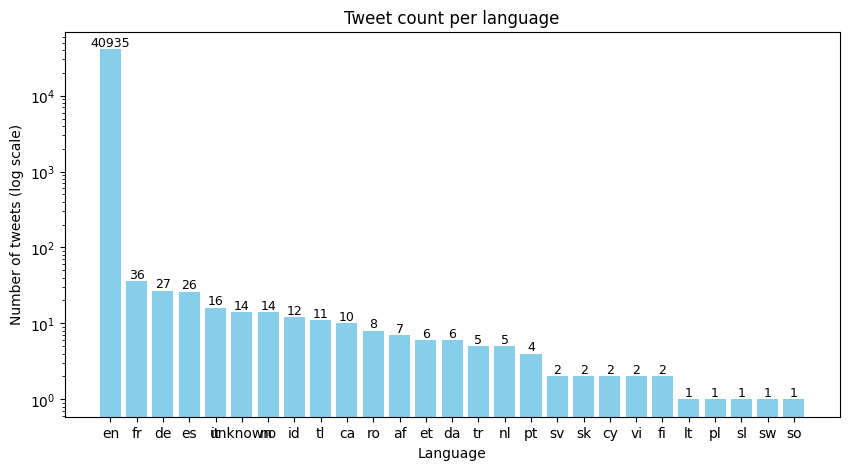

In [82]:
# Count languages
lang_counts = train['lang'].value_counts()

fig, ax = plt.subplots(figsize=(10,5))

# Bar plot
bars = ax.bar(lang_counts.index, lang_counts.values, color="skyblue")

# Log scale (so English doesn’t dominate)
ax.set_yscale("log")

# Numbers above each bar
for bar, count in zip(bars, lang_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, 
            count, 
            str(count), 
            ha='center', va='bottom', fontsize=9)

ax.set_title("Tweet count per language")
ax.set_xlabel("Language")
ax.set_ylabel("Number of tweets (log scale)")

plt.show()


So as we can see, most of the tweets are in english so we will remove the others because it is not much and starting to translate it may cause some bias. <br><br>

We also relized that tweets contain a lot of **URLs**, most of them really not informative at all because we know tokenizer can encode them also if there are some useful words(BPE encoder knows how to handle it, because we took DeBERTas' model tokenizer(because we are willing to use DeBERTa and fine-tune it to a sentiment analysis classification task) and we saw that useful links, hashtags, @ signs and others are something that is handled but CapsLock and repeated dots and dashes are something that is bad in tokenization and context understanding so we removed it also. <br> 
Another interesting behavior of tokenizers we saw is that they know to handle a lot of spaces and '\r\r\n\n' carrigage return characters. <br>
The code we tried to see some data behavior with the tokenizer: 

In [83]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

# Some examples to test how the tokenizer behaves to give us a better prespective about relevant and effective pre-processing: 
texts = [
    "StayHomeStaySafe", 
    "##StayHomeStaySafe",
    "#coronavirus",
    "https://web.based.models.com\r\r\r\n\n     hey hahah",
    "debertabasedmodel... ALSO there is a ", 
    "hello, HELLO","@hey tim", 
    "---- tali --hey --how-- are --you ##funnyAs hell "
]

for t in texts:
    tokens = tokenizer.tokenize(t)
    ids = tokenizer.encode(t, add_special_tokens=True)
    print(f"\nText: {t}")
    print("Tokens:", tokens)
    print("IDs:", ids)



Text: StayHomeStaySafe
Tokens: ['▁Stay', 'Home', 'Stay', 'Safe']
IDs: [1, 5898, 13113, 37478, 25305, 2]

Text: ##StayHomeStaySafe
Tokens: ['▁#', '#', 'Stay', 'Home', 'Stay', 'Safe']
IDs: [1, 953, 2669, 37478, 13113, 37478, 25305, 2]

Text: #coronavirus
Tokens: ['▁#', 'co', 'rona', 'virus']
IDs: [1, 953, 1902, 46835, 18012, 2]

Text: https://web.based.models.com

     hey hahah
Tokens: ['▁https', ':', '/', '/', 'web', '.', 'based', '.', 'models', '.', 'com', '▁hey', '▁haha', 'h']
IDs: [1, 3597, 294, 320, 320, 9839, 260, 1173, 260, 60658, 260, 549, 11187, 15731, 1537, 2]

Text: debertabasedmodel... ALSO there is a 
Tokens: ['▁deb', 'erta', 'based', 'model', '.', '.', '.', '▁ALSO', '▁there', '▁is', '▁a']
IDs: [1, 63504, 48299, 1173, 19928, 260, 260, 260, 23987, 343, 269, 266, 2]

Text: hello, HELLO
Tokens: ['▁hello', ',', '▁HELLO']
IDs: [1, 12018, 261, 84173, 2]

Text: @hey tim
Tokens: ['▁@', 'hey', '▁tim']
IDs: [1, 1944, 22740, 41718, 2]

Text: ---- tali --hey --how-- are --you ##funnyA

The number of URLs that have uninformative data/content:

In [84]:

pat_short = re.compile(r"https?://(?:t\.co|tinyurl\.com)/\S+", re.IGNORECASE)

train["has_shortener"] = train["OriginalTweet"].str.contains(pat_short, na=False)
n_short = train["has_shortener"].sum()
pct_short = n_short / len(train) if len(train) else 0.0

print(f"Tweets with t.co or tinyurl: {n_short} / {len(train)} ({pct_short:.1%})")


Tweets with t.co or tinyurl: 19803 / 41157 (48.1%)


So we will also remove and replace these URL types with space strings `' '`
<br><br>

And now to conclude, the pre-processing phase we will apply before doing any interesting visualization on the tweets column called OriginalTweet will be: 

1. converting repeated dashes, dots, and punctuations that repeat themself more than two times included twice and convert it to appear only once. 
2. then we applied we applied fix_text method from ftfy library 
3. then we applied lowercasing 
4. then remove languages that are not english from the corpus 
5. then convert every tinyurl and t.co to empty string ''.
6. every emoji that is similar to copyright sign after conversion or R sign convrt it to an empty string
7. if the majority of the tweet(60% of the words/tokens) contains only user tagged(might happen) we will remove this tweet. 
<br>
This order matters so we won't loose any information on the way of doing this trandormation.
The code that contains it all is: 

In [85]:
DetectorFactory.seed = 0

# 1) collapse repeated dashes/dots/punct (>1 extra -> keep one)
RE_PUNCT_RUN = re.compile(r"([\-–—_.!,?:;])\1{1,}")

# 5) tinyurl / t.co -> ''
RE_SHORT = re.compile(r"https?://(?:t\.co|tinyurl\.com)/\S+", re.IGNORECASE)

# 6) remove © and ®
RE_COPY_R = re.compile(r"[©®]")

RE_USER = re.compile(r"^@\w+$")

def preprocess_tweet(text: str)->str:
    if not isinstance(text, str):
        return None
    # 1 collapse repeated punctuations
    text = RE_PUNCT_RUN.sub(r"\1", text)
    # 2 fix text artifacts
    text = fix_text(text)
    # 3 lowercase
    text = text.lower()
    # 4 keep only English
    try:
        if detect(text) != "en":
            return None
    except Exception:
        return None
    # 5 remove shorteners to space
    text = RE_SHORT.sub(" ", text)
    # 6 remove © and ® to space
    text = RE_COPY_R.sub(" ", text)
    # clean whitespace
    text = re.sub(r"\s+", " ", text).strip() # not really necessary for tokenizers, they know to deal with only spaces but still 
    if not text:
        return None
    # 7 drop if majority of tokens are @mentions
    tokens = text.split()
    if tokens:
        user_like = sum(tok.startswith("@") for tok in tokens)
        if user_like / len(tokens) >= 0.6:
            return None
    return text


# apply to your dataframe
train["clean_text"] = train["OriginalTweet"].apply(preprocess_tweet)

So now we can do some visualization, to see word frequencies and tweeets lenghts so we can gain some interesting futher insights. 

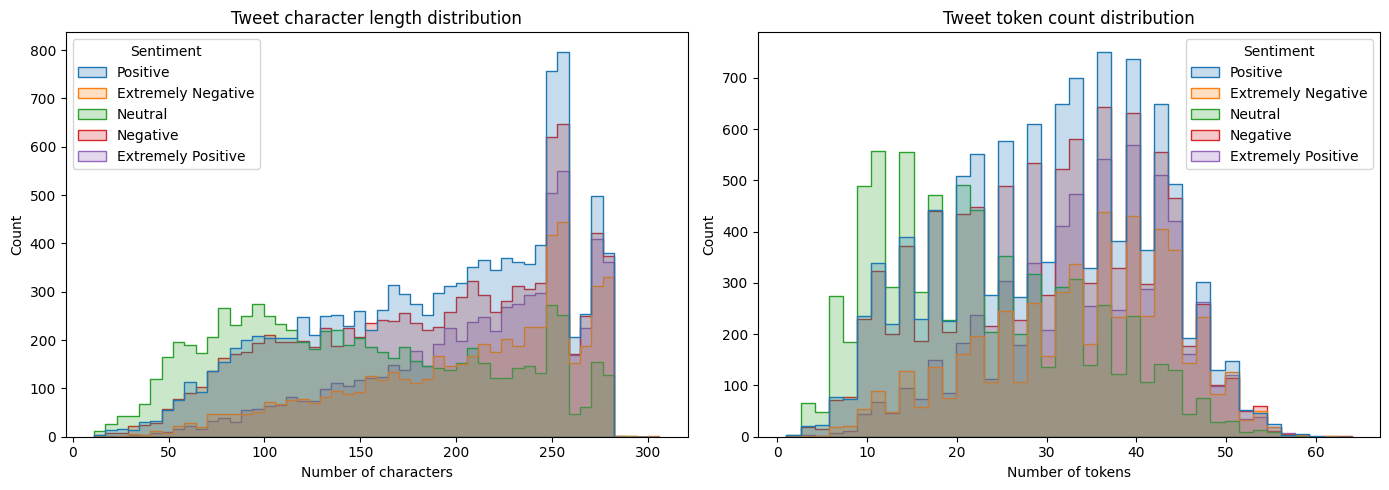


Tweet length summary (per sentiment):

                   n_chars                n_tokens              
                      mean   std min  max     mean   std min max
Sentiment                                                       
Extremely Negative   206.7  58.3  14  306     34.0  10.6   2  61
Extremely Positive   210.8  54.1  21  283     34.3   9.8   2  62
Negative             187.0  65.2  14  282     30.2  11.4   1  64
Neutral              148.4  69.0  11  291     22.6  11.2   1  59
Positive             189.3  63.9  12  281     30.4  11.3   1  60


In [86]:
nltk.download('stopwords')
stop = set(stopwords.words("english"))
covid_words = {"covid","covid19","covid-19","coronavirus","virus","corona"}

df = train[train["clean_text"].notna()].copy()
df["n_chars"] = df["clean_text"].str.len()
df["n_tokens"] = df["clean_text"].str.split().str.len()

# =============== 1. Length Distributions ===================
fig, axes = plt.subplots(1,2, figsize=(14,5))

sns.histplot(data=df, x="n_chars", hue="Sentiment", bins=50, ax=axes[0], element="step")
axes[0].set_title("Tweet character length distribution")
axes[0].set_xlabel("Number of characters")

sns.histplot(data=df, x="n_tokens", hue="Sentiment", bins=40, ax=axes[1], element="step")
axes[1].set_title("Tweet token count distribution")
axes[1].set_xlabel("Number of tokens")

plt.tight_layout()
plt.show()

# Summary table (mean ± std)
length_summary = df.groupby("Sentiment")[["n_chars","n_tokens"]].agg(["mean","std","min","max"]).round(1)
print("\nTweet length summary (per sentiment):\n")
print(length_summary)

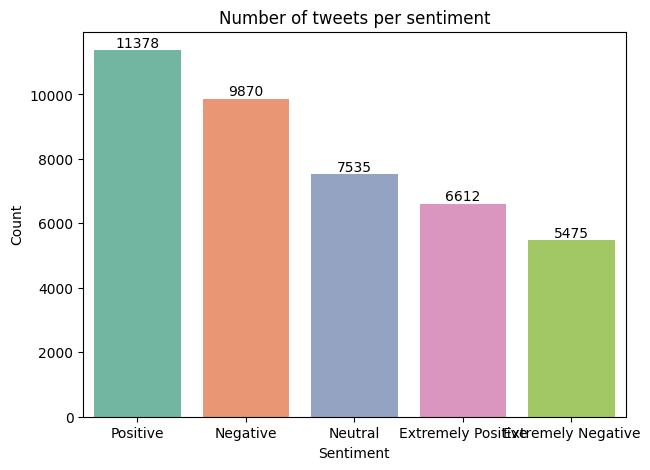


Sentiment Distribution Table:

| Sentiment          |   Count |   Proportion (%) |
|--------------------|---------|------------------|
| Positive           |   11378 |            27.84 |
| Negative           |    9870 |            24.15 |
| Neutral            |    7535 |            18.44 |
| Extremely Positive |    6612 |            16.18 |
| Extremely Negative |    5475 |            13.4  |


In [87]:
# =============== 2. Sentiment Proportion ===================
sent_counts = df["Sentiment"].value_counts()
sent_props = (sent_counts / len(df) * 100).round(2)
prop_df = pd.DataFrame({"Count": sent_counts, "Proportion (%)": sent_props})

plt.figure(figsize=(7,5))
sns.barplot(x=prop_df.index, y=prop_df["Count"], palette="Set2")
for i, v in enumerate(prop_df["Count"]):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title("Number of tweets per sentiment")
plt.ylabel("Count")
plt.show()

print("\nSentiment Distribution Table:\n")
from tabulate import tabulate
print(tabulate(prop_df, headers="keys", tablefmt="github"))

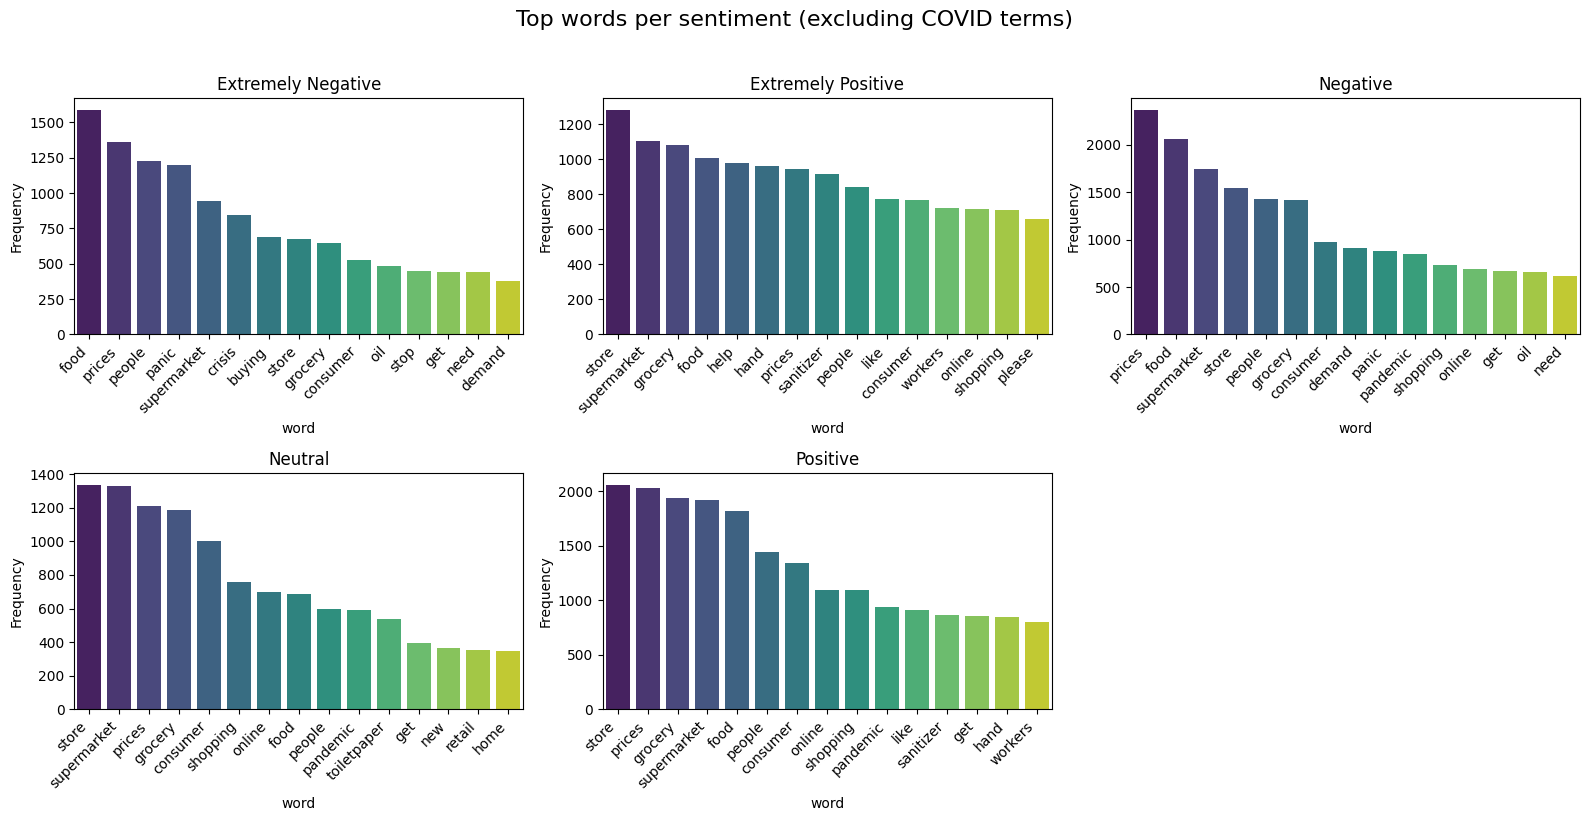

In [88]:
def get_top_words(texts, n=15):
    words=[]
    for t in texts:
        toks = re.findall(r"[a-z']+", t.lower())
        toks = [w for w in toks if w not in stop and w not in covid_words and len(w)>2]
        words.extend(toks)
    return Counter(words).most_common(n)

sentiments = sorted(df["Sentiment"].unique())  # sort for consistent order
n_sent = len(sentiments)

# choose grid size (e.g. 2 rows x 3 cols if 5 sentiments)
n_cols = 3
n_rows = int(np.ceil(n_sent / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows), sharey=False)

axes = axes.flatten()

for i, sent in enumerate(sentiments):
    ax = axes[i]
    top_words = get_top_words(df.loc[df["Sentiment"]==sent, "clean_text"], n=15)
    top_df = pd.DataFrame(top_words, columns=["word","count"])
    sns.barplot(data=top_df, x="word", y="count", palette="viridis", ax=ax)
    ax.set_title(f"{sent}")
    ax.set_ylabel("Frequency")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Top words per sentiment (excluding COVID terms)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


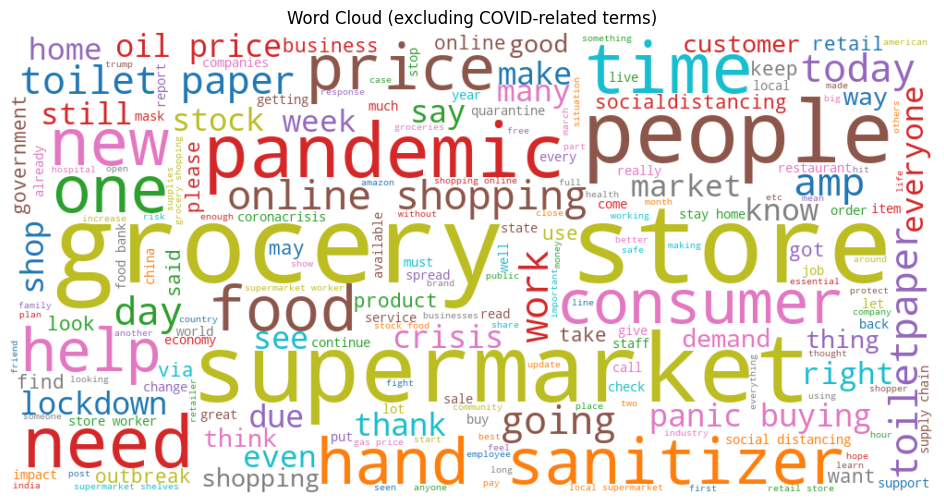

In [89]:
# =============== 4. Word Cloud (all tweets, excluding COVID) ============================
all_text = " ".join(df["clean_text"])
tokens = [w for w in re.findall(r"[a-z']+", all_text.lower()) 
          if w not in stop and w not in covid_words and len(w)>2]

wordcloud = WordCloud(width=1000, height=500, background_color="white", colormap="tab10")\
             .generate(" ".join(tokens))

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud (excluding COVID-related terms)")
plt.show()

Based on the following, we can see there is a **class imbalance** we will probably try to use some relevant sampling methods or use in `nn.CrossEntropy()` with the weight argument which gets percentage so the loss gets bigger if we got wrong in the minority classes. 
<br><br>
We can see interesting word cloud but more interesting is that in the negative sentiment the word prices is the most common but in the extremly negative it is food, they are related but still very intersting that neutral and extremly positive have same highest frequent word "store".